In [2]:
import pickle
from functools import partial

import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from models import DeepConditionalModel, InvariantNetwork
from losses import maximum_likelihood_loss
from inn_utils import train_online_ml, compute_metrics
from viz import plot_losses, plot_variance, plot_metrics_params
import diagnostics as diag

In [3]:
np.set_printoptions(suppress=True)

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
tf.enable_eager_execution()

# MVN Gaussian class

In [7]:
class GaussianModel:
    
    def __init__(self, d, random_state=42):
        """
        Implements a toy MVN Gaussian model. The argument d determines
        the dimensionality of the distribution.
        """

        self.d = d
        sigma = stats.wishart.rvs(d, scale=np.identity(d) / d, random_state=random_state)
        self.sigma = tf.convert_to_tensor(sigma, dtype=tf.float32)
        self.inv_sigma = tf.linalg.inv(self.sigma)
        self.inv_sigma_mu = tf.eye(d) + self.inv_sigma
        self.sigma_mu = tf.linalg.inv(self.inv_sigma_mu) 
        
        
    def __call__(self, batch_size):
        return self.generate_datasets(batch_size)
    
    def generate_datasets(self, batch_size, return_cov=False):
        
        mu_x = tf.random_normal(shape=(batch_size, self.d))
        sigma_x = self.sigma
        x = tfp.distributions.MultivariateNormalFullCovariance(mu_x, sigma_x).sample()
        
        if return_cov:
            return x, mu_x, sigma_x
        return x, mu_x
    
    def compute_posterior(self, batch_size, x, sigma_x):
        """
        Computes the posterior mean given identity prior covariance and zero prior mean.
        x is a batch of means
        cov_x is a batch of covariance matrices
        """
        
        mu_p = tf.matmul(tf.matmul(self.sigma_mu, self.inv_sigma), tf.transpose(x))
        mu_p = tf.transpose(mu_p)
                         
        return mu_p, self.sigma_mu

    def generate_with_posterior(self, batch_size):
        
        x, mu_x, sigma_x = self.generate_datasets(batch_size, return_cov=True)
        mu_p, sigma_p = self.compute_posterior(batch_size, x, sigma_x)
        return x, mu_x, mu_p, sigma_p
    
    def KL(self, mu_true, sigma_true, mu_hat, sigma_hat):
        """
        Computes the KL divergence between two Gaussians.
        """
        
        d = int(mu_true.shape[1])
        inv_sigma_hat = tf.linalg.inv(sigma_hat)
        mu_diff = mu_hat - mu_true
        kl = tf.log1p(tf.linalg.det(sigma_hat)) - tf.log1p(tf.linalg.det(sigma_true))
        kl -= d
        kl += tf.linalg.trace(tf.matmul(inv_sigma_hat, sigma_true))
        kl += tf.einsum('mj,mj->m',tf.einsum('mi,mij->mj', mu_diff, inv_sigma_hat), mu_diff)
        kl *= 0.5
        return max(tf.reduce_mean(kl), 0)

# Helper functions

In [68]:
def plot_metrics(samples, theta_p, figsize=(10, 6), filename=None):
    """Plots R2 and NRMSE over all parameters."""
    
    plt.rcParams['font.size'] = 14
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(diag.rmse(samples, theta_p), label='NRMSE', linewidth=2)
    ax.plot(diag.R2(samples, theta_p), label='R2', linewidth=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()
    ax.set_xlabel('Parameter #')
    plt.show()
    
    if filename is not None:
        f.savefig("figures/Metrics_{}.png".format(filename), dpi=600, bbox_inches='tight')
    
def covariance_matrix(samples, ddof=1):
    """A memory efficient function for comuting the covariance for a batch of samples."""
    
    samples_means = tf.reduce_mean(samples, axis=0)
    samples_c = samples - samples_means
    if len(samples.shape) == 3:
        n = int(samples.shape[1]) # number of test datasets
        m = int(samples.shape[0]) # number of points per dimensions
        covs = [tf.matmul(tf.transpose(samples_c[:, i, :], [1, 0]), samples_c[:, i, :]) / (m - ddof) for i in range(n)]
        covs = tf.stack(covs, axis=0)
    elif len(samples.shape) == 2:
        m = int(samples.shape[0]) # number of points per dimensions
        covs = tf.matmul(tf.transpose(samples_c, [1, 0]), samples_c) / (m - ddof)
    return covs

def plot_joint(samples, theta_p, param_names, filename=None, figsize=(10, 6)):
    """
    Plots joint recovery plots on the full test sample.
    """
    
    samples_m = samples.numpy().mean(0)
    theta_p = theta_p.numpy()
    n_test = int(theta_p.shape[0])

    to_plot = np.concatenate((theta_p, samples_m), axis=0)
    all_params = pd.DataFrame(to_plot, columns=param_names)
    all_params['Legend'] = ['Analytic'] * n_test + ['Estimated'] * n_test 

    g = sns.PairGrid(all_params, hue="Legend", palette={'Analytic': '#e55e5e', 'Estimated': '#5c92e8'})
    g.map_upper(sns.scatterplot, alpha=0.9)
    g.map_lower(sns.kdeplot, alpha=0.9)
    g.map_diag(sns.distplot, hist=True, hist_kws=dict(edgecolor="k", linewidth=1, alpha=0.9))
    g.add_legend(title="", shadow=True)
    g._legend.set_bbox_to_anchor((1.05, 0.5))
    g.fig.set_figwidth(figsize[0])
    g.fig.set_figheight(figsize[1])
    if filename is not None:
        g.savefig('figures/MVN_{}.png'.format(filename), dpi=600)

# 5-D Gaussian

In [75]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
theta_dim = 5
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 25
iterations_per_epoch = 1000
n_inv_blocks = 3
n_points = 1000
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [76]:
# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [77]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [78]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_5d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/gaussian_5d\ckpt-6


In [79]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

## Train the model

In [80]:
# %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
#         # Run training loop
#         train_online_ml(model, optimizer, mvn_gaussian, iterations_per_epoch, 
#                         batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
#                         transform=None, n_smooth=100)
        
#         # Test performance
#         samples = model.sample(X_test, n_samples_posterior)
#         samples_mean = tf.reduce_mean(samples, axis=0)
#         samples_cov = tfp.stats.covariance(samples, sample_axis=0)
#         f, ax = plt.subplots(1, 5, figsize=(14, 2))
#         for i in range(theta_dim):
#             ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
#         plt.show()

#         # Test KL
#         print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

#         # Save model
#         manager.save()

## Evaluate performance

In [85]:
# Test performance
samples = model.sample(X_test, n_samples_posterior)
samples_mean = tf.reduce_mean(samples, axis=0)
samples_cov = covariance_matrix(samples)

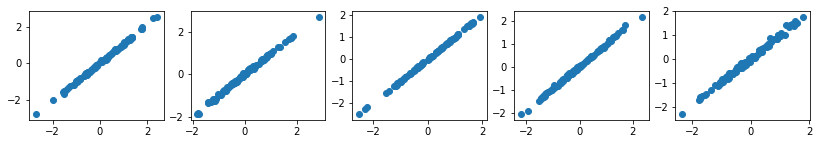

KL:  0


In [86]:
f, ax = plt.subplots(1, 5, figsize=(14, 2))
for i in range(5):
    ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
plt.show()

# Test KL
print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

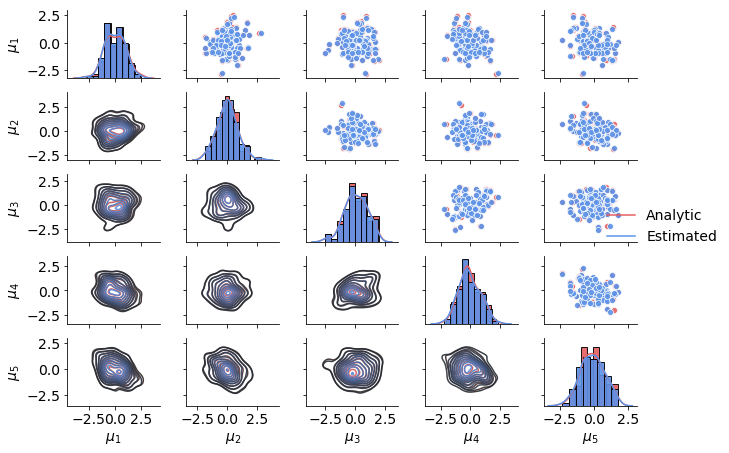

In [89]:
plot_joint(samples, theta_p, params_names, '5d')

# 50-D Gaussian

In [13]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
train = False
theta_dim = 50
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 3
n_points = 1000
n_test = 100
n_test2 = 3
n_samples_posterior = 5000
starter_learning_rate = 0.001
decay_steps = 5000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)


# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [14]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [15]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_50d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [16]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

## Train

In [19]:
# %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
#         # Run training loop
#         train_online_ml(model, optimizer, mvn_gaussian, iterations_per_epoch, 
#                         batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
#                         transform=None, n_smooth=100)
        
#         # Test performance
#         samples = model.sample(X_test, n_samples_posterior)
#         samples_mean = tf.reduce_mean(samples, axis=0)
#         samples_cov = covariance_matrix(samples)
        
#         # Plot stuff
#         f, ax = plt.subplots(5, 5, figsize=(12, 6))
#         for i in range(25):
#             ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
#         plt.show()
        
#         plot_metrics(samples, theta_p)

#         # Test KL
#         print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

#         # Save model
#         manager.save()

## Evaluate performance

In [20]:
samples = model.sample(X_test, n_samples_posterior)
samples_mean = tf.reduce_mean(samples, axis=0)
samples_cov = covariance_matrix(samples)

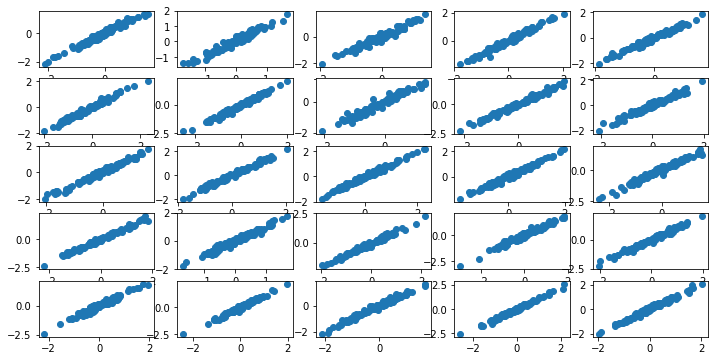

KL:  0


In [22]:
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
plt.show()

# Test KL
print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

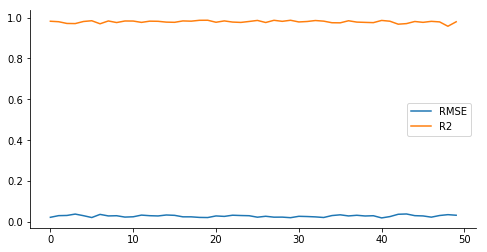

In [71]:
plot_metrics(samples, theta_p, figsize=(8, 4))

# 500-D Gaussian

In [27]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [256, 256, 256],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
theta_dim = 500
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 6
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [28]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [29]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_500d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/gaussian_500d\ckpt-68


In [30]:
# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [31]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

## Train

In [131]:
# %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
#         # Run training loop
#         train_online_ml(model, optimizer, mvn_gaussian, iterations_per_epoch, 
#                         batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
#                         transform=None, n_smooth=100)
        
#         # Test performance
#         samples = tf.concat([model.sample(X_test, 100) for _ in range(20)], axis=0)
#         samples_mean = tf.reduce_mean(samples, axis=0)
#         samples_cov = covariance_matrix(samples)
        
#         # Plot stuff
#         f, ax = plt.subplots(5, 5, figsize=(12, 6))
#         for i in range(25):
#             ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
#         plt.show()
        
#         plot_metrics(samples, theta_p)

#         # Test KL
#         print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov).numpy())

#         # Save model
#         manager.save()

## Evaluate performance|

In [52]:
%%time
means = []
covariances = []
n = int(X_test.shape[0])
for i in range(n):
    samples = tf.concat([model.sample(X_test[i:(i+1)], 500) for _ in range(100)], axis=0)
    covariances.append(covariance_matrix(samples))
    means.append(tf.reduce_mean(samples, axis=0))

Wall time: 6min 30s


In [53]:
samples_mean = tf.stack(means)
samples_cov = tf.stack(covariances)

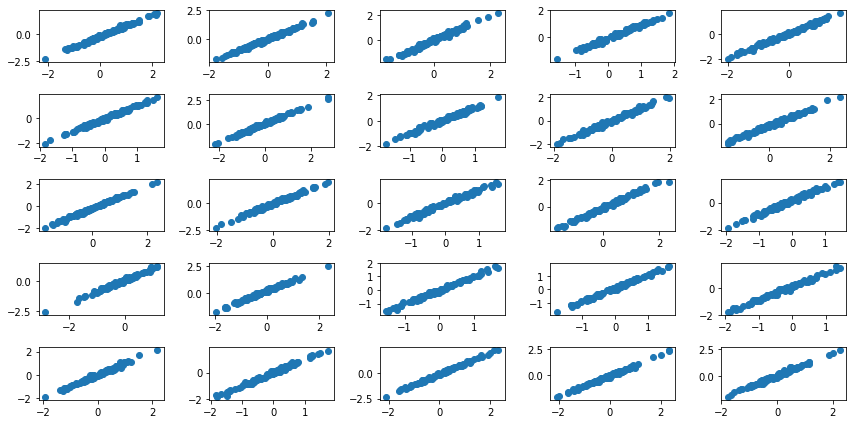

In [47]:
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
plt.tight_layout()
plt.show()

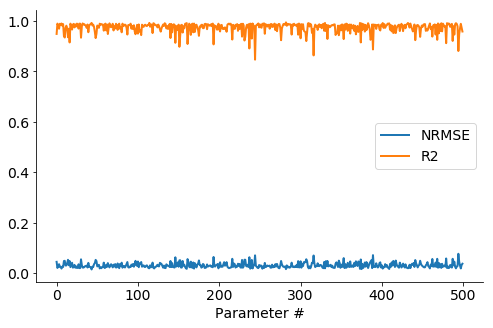

In [69]:
plot_metrics(tf.expand_dims(samples_mean, axis=0), theta_p, figsize=(8, 5), filename='MVN_500')

In [55]:
print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov).numpy())

KL:  0.36523315
